In [1]:
# python自带
import gc
import os
import re
import random
from lxml import etree
from queue import Queue

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [3]:
# 科学计算
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tensorboardX import SummaryWriter

In [4]:
# NLP 相关
import jieba
import torchtext

In [5]:
# 画图
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
import seaborn as sns

myfont=FontProperties(fname=r'/home/zyc/Downloads/SimHei.ttf',size=14)

sns.set(font=myfont.get_name())

% matplotlib inline

In [6]:
def tokenizer(src):
    return src.split(' ')

In [7]:
SRC = torchtext.data.Field(tokenize=tokenizer, eos_token='<eos>')
TRG = torchtext.data.Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>')

dataset = torchtext.datasets.TranslationDataset(
    path='data/NEU',
    exts=('.en.tok.bpe', '.zh.tok'),
    fields=(SRC, TRG)
)

In [8]:
train_data, dev_data = dataset.split(split_ratio=0.98)

In [9]:
dev_data, test_data = dev_data.split(split_ratio=0.5)

In [10]:
print(len(train_data))
print(len(test_data))
print(len(dev_data))

1959416
19994
19994


In [11]:
SRC.build_vocab(train_data.src, dev_data.src, test_data.src, max_size=50000)

In [12]:
TRG.build_vocab(train_data.trg, dev_data.trg, test_data.trg, max_size=50000)

In [13]:
print(len(SRC.vocab.itos))
print(len(TRG.vocab.itos))

32115
50004


In [14]:
SRC.vocab.itos[-10:]

['souri',
 'staur@@',
 'susp@@',
 'tellig@@',
 'therto',
 'thwest',
 'tremend@@',
 'ublic',
 'usetts',
 'warri@@']

In [15]:
SRC.vocab.load_vectors(torchtext.vocab.Vectors('data/glove.840B.300d.txt'))

In [16]:
TRG.vocab.load_vectors(torchtext.vocab.Vectors('data/sgns.target.word-word.dynwin5.thr10.neg5.dim300.iter5'))

In [17]:
class Encoder(nn.Module):
    '''Encoder(bi-GRU)
    '''
    def __init__(self, pretrained_embed, padding_idx, fix, hidden_size,
                 n_layers=1, dropout=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embed)
        self.embedding.padding_idx = padding_idx
        if fix:
            self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding.embedding_dim, hidden_size, n_layers,
                            dropout=dropout, bidirectional=True)

    def forward(self, src, hidden=None):
        '''
        Inputs:
            src: input word index
            hidden: h_t-1 (num_layers * num_directions, batch, hidden_size)
        Outputs:
            output: [T*B*H]
            hidden: h_t
        '''
        embeded = self.embedding(src)
        outputs, hidden = self.gru(embeded, hidden)
        
        # Sum bi-lstm outputs
        output = (outputs[:, :, :self.hidden_size] + 
                   outputs[:, :, self.hidden_size:])
    
        return output, hidden


class ConcatAttn(nn.Module):
    '''Attention(concat)
    Params:
        hidden_size: hidden size
    '''
    def __init__(self, hidden_size):
        super(ConcatAttn, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1.0 / sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)
    
    def forward(self, hidden, encoder_output):
        '''
        Inputs:
            hidden: [1*B*H] 
            encoder_output: [T*B*H]
        Outputs:
            energy: normalised weights [B*1*T]
        '''
        # Expand hidden [1*B*H] -> [T*B*H] -> [B*T*H]
        hidden = hidden.repeat(encoder_output.size(0), 1, 1).transpose(0, 1)

        # Transfer encoder_output to [B*T*H]
        encoder_output = encoder_output.transpose(0, 1)

        # Calculate energy and normalise  [B*1*T]
        attn_energy = self.score(hidden, encoder_output)
        return F.softmax(attn_energy, dim=2)

    def score(self, hidden, encoder_output):
        '''
        Inputs:
            hidden: [B*T*H]
            encoder_output: [B*T*H]
        Outputs:
            attn_energy: weights [B*T]
        '''
        # Project vectors [B*T*2H] -> [B*T*H] -> [B*H*T]
        energy = self.attn(torch.cat([hidden, encoder_output], 2))
        energy = energy.transpose(1, 2)
        
        # Expend v  [H] -> [B*H] -> [B*1*H]
        v = self.v.repeat(encoder_output.size(0), 1).unsqueeze(1)
        
        # [B*1*H] * [B*H*T] -> [B*1*T]
        attn_energy = torch.bmm(v, energy)
        return attn_energy

        
class BilinearAttn(nn.Module):
    '''Attention(bilinear)
    Params:
        hidden_size: hidden size
    '''
    def __init__(self, hidden_size):
        super(BilinearAttn, self).__init__()
        self.hidden_size = hidden_size
        self.bilinear = nn.Linear(hidden_size, hidden_size)

    
    def forward(self, hidden, encoder_output):
        '''
        Inputs:
            hidden: [1*B*H] 
            encoder_output: [T*B*H]
        Outputs:
            energy: normalised weights [B*1*T]
        '''
        # [T*B*H] -> [T*B*H] -> [B*H*T]
        wh = self.bilinear(encoder_output).permute(1, 2, 0)
        
        # [1*B*H] -> [B*1*H] x [B*H*T] => [B*1*T]
        score = hidden.transpose(0, 1).bmm(wh)
        
        return F.softmax(score, dim=2)
    


class Decoder(nn.Module):
    '''Decoder(bi-GRU)
    '''
    def __init__(self, pretrained_embed, padding_idx, hidden_size, fix, output_size,
                 n_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.embedding = nn.Embedding.from_pretrained(pretrained_embed)
        self.embedding.padding_idx = padding_idx
        if fix:
            self.embedding.weight.requires_grad = False
            
        self.dropout = nn.Dropout(dropout, inplace=True)
        
        self.attention = BilinearAttn(hidden_size)
        
        self.gru = nn.GRU(
            self.embedding.embedding_dim,
            hidden_size,
            n_layers,
            dropout=dropout
        )
        
        self.linear1 = nn.Linear(hidden_size * 2, hidden_size * 2, bias=False)
        self.linear2 = nn.Linear(hidden_size * 2, output_size, bias=False)

    def forward(self, input, hidden, encoder_output):
        '''
        Inputs:
            input: [B]
            hidden: [layers*B*H]
            encoder_output: [T*B*H]
        Outputs:
            p: [B*O]
            hidden: [layers*B*H]
        '''
        # [B] -> [B*E] -> [1*B*E]
        embeded = self.embedding(input).unsqueeze(0) 
            
        # [1*B*H], [layers*B*H]
        output, hidden = self.gru(embeded, hidden)
        
        # ht: [B*H]  the last layer
        ht = hidden[-1, :, :]
        
        # [1*B*T] and [T*B*H] -> [B*1*T]
        attn_weights = self.attention(ht.unsqueeze(0), encoder_output)
        
        # [B*1*T] x [B*T*H] => [B*1*H] -> [B*H]
        c = attn_weights.bmm(encoder_output.transpose(0, 1)).squeeze(1)
        
        # concat c and h => [B*2H] => [B*H] 
        attn_vector = torch.tanh(self.linear1(
            torch.cat([c, ht], dim=1)
        ))
        
        # [B*H] -> [B*O]
        p = F.log_softmax(self.linear2(attn_vector), dim=1)
        
        return p, hidden, attn_weights


In [18]:
batch_size = 32

In [19]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

dev_iter = torchtext.data.BucketIterator(
    dataset=dev_data,
    batch_size=batch_size,
    shuffle=True
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True
)

In [20]:
def training(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer ,criterion, eval_steps, train_iter, dev_iter, device, writer, warmup):
    encoder.to(device)
    decoder.to(device)
    
    step = 0
    train_loss = 0.0
    lowest_loss = 1e5
    
    encoder.train()
    decoder.train()
    for e in range(epoch):
        if e == warmup:
            encoder.embedding.weight.requires_grad = True
            decoder.embedding.weight.requires_grad = True
            encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-4)
            decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=1e-4)
        
        train_iter.init_epoch()
        for train_batch in iter(train_iter):
            step += 1
            
            # [T*B]
            src = train_batch.src.to(device)
            trg = train_batch.trg.to(device)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            # encoder
            encoder_output, hidden = encoder(src)
            
            # decoder            
            hidden = hidden[:decoder.n_layers]
            decoder_input = trg[0] # SOS
            
            loss = 0.0
            for i in range(trg.size(0) - 1):
                p, hidden, _ = decoder(
                    decoder_input, hidden, encoder_output
                )
                loss += criterion(p, trg[i+1])
                decoder_input = trg[i+1]
                
            loss.backward()
            train_loss += loss.item() / (trg.size(0) - 1)
            clip_grad_norm_(encoder.parameters(), 0.5)
            clip_grad_norm_(decoder.parameters(), 0.5)
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            if (step % eval_steps) == 0:
                with torch.no_grad():
                    encoder.eval()
                    decoder.eval()
                    
                    dev_iter.init_epoch()
                    dev_loss = 0.0
                    dev_step = 0
                    for dev_batch in iter(dev_iter):
                        dev_step += 1
                        dev_src = dev_batch.src.to(device)
                        dev_trg = dev_batch.trg.to(device)
                        
                        encoder_output, hidden = encoder(dev_src)
                        hidden = hidden[:decoder.n_layers]
                        decoder_input = dev_trg[0]
                        loss = 0.0
                        for i in range(dev_trg.size(0) - 1):
                            p, hidden, _ = decoder(
                                decoder_input, hidden, encoder_output
                            )
                            loss += criterion(p, dev_trg[i+1])
                            decoder_input = dev_trg[i+1] 
                        
                        dev_loss += loss.item() / (dev_trg.size(0) - 1)
                    
                    train_loss /= eval_steps
                    dev_loss /= dev_step
                    print("epoch %d steps %d train_loss %.4f train_ppl %5.2f dev_loss %.4f dev_ppl %5.2f" % (
                        e, step, train_loss, np.exp(train_loss), dev_loss, np.exp(dev_loss)
                    ))
                    
                    writer.add_scalar('train/loss', train_loss, step)
                    writer.add_scalar('train/perplexity', np.exp(train_loss), step)
                    writer.add_scalar('dev/loss', dev_loss, step)
                    writer.add_scalar('dev/perplexity', np.exp(dev_loss), step)
                    
                    if dev_loss < lowest_loss:
                        lowest_loss = dev_loss
                        save(
                            encoder=encoder,
                            decoder=decoder,
                            info={'steps':step, 'epoch':e, 'train_loss':train_loss, 'train_ppl':np.exp(train_loss), 'dev_loss':dev_loss, 'dev_ppl':np.exp(dev_loss)}
                        )
                    
                    train_loss = 0.0
                    encoder.train()
                    decoder.train()

def save(encoder, decoder, info):
    torch.save(info, 'best_model.info')
    torch.save(encoder.state_dict(), 'best_encoder.m')
    torch.save(decoder.state_dict(), 'best_decoder.m')
    
def load():
    encoder = Encoder(pretrained_embed=SRC.vocab.vectors, padding_idx=SRC.vocab.stoi[SRC.pad_token], fix=True, hidden_size=1000, dropout=0.3, n_layers=4)
    decoder = Decoder(pretrained_embed=TRG.vocab.vectors, padding_idx=TRG.vocab.stoi[TRG.pad_token], fix=True, hidden_size=1000, dropout=0.3, n_layers=4, output_size=len(TRG.vocab.itos))
    encoder.load_state_dict(torch.load('best_encoder.m'))
    decoder.load_state_dict(torch.load('best_decoder.m'))
    encoder.eval()
    decoder.eval()
    info = torch.load('best_model.info')
    return encoder, decoder, info

In [21]:
choise = "cuda" if torch.cuda.is_available() else "cpu"
print(choise + " is available")
device = torch.device(choise)

cuda is available


In [ ]:
encoder = Encoder(pretrained_embed=SRC.vocab.vectors, padding_idx=SRC.vocab.stoi[SRC.pad_token], fix=True, hidden_size=1000, dropout=0.3, n_layers=4)
decoder = Decoder(pretrained_embed=TRG.vocab.vectors, padding_idx=TRG.vocab.stoi[TRG.pad_token], fix=True, hidden_size=1000, dropout=0.3, n_layers=4, output_size=len(TRG.vocab.itos))

encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-4)
decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=1e-4)

criterion = nn.NLLLoss()

writer = SummaryWriter()
training(epoch=20, encoder=encoder, decoder=decoder, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, 
         criterion=criterion, eval_steps=1000, train_iter=train_iter, dev_iter=dev_iter, device=device, writer=writer, warmup=1)

epoch 0 steps 1000 train_loss 3.5105 train_ppl 33.46 dev_loss 3.2044 dev_ppl 24.64
epoch 0 steps 2000 train_loss 3.1038 train_ppl 22.28 dev_loss 2.9857 dev_ppl 19.80
epoch 0 steps 3000 train_loss 2.9334 train_ppl 18.79 dev_loss 2.8602 dev_ppl 17.46
epoch 0 steps 4000 train_loss 2.8476 train_ppl 17.25 dev_loss 2.7595 dev_ppl 15.79
epoch 0 steps 5000 train_loss 2.7630 train_ppl 15.85 dev_loss 2.7153 dev_ppl 15.11


In [23]:
encoder, decoder, info = load()
info

{'steps': 226000,
 'epoch': 3,
 'train_loss': 1.6976676134959283,
 'train_ppl': 5.461194908347954,
 'dev_loss': 1.700731337990908,
 'dev_ppl': 5.477952161656701}

In [24]:
class Node(object):
    def __init__(self, hidden, previous_node, decoder_input, attn, log_prob, length):
        self.hidden = hidden
        self.previous_node = previous_node
        self.decoder_input = decoder_input
        self.attn = attn
        self.log_prob = log_prob
        self.length = length        

In [25]:
def beam_search(src, beam_width=3):
    words = tokenizer(src) 
    indices = [SRC.vocab.stoi[word] for word in words]
    print(indices)
    input_tensor = torch.LongTensor(indices).unsqueeze(1)
    # [1*T]
    encoder_output, hidden = encoder(input_tensor)
    hidden = hidden[:decoder.n_layers]
    decoder_input = torch.tensor(2).unsqueeze(0)
    
    node = Node(hidden, None, decoder_input, None, 0, 1)
    q = Queue()
    q.put(node)
    
    end_nodes = []
    while not q.empty():
        candidates = []
        # level traversal
        for _ in range(q.qsize()):
            node = q.get()
            decoder_input = node.decoder_input
            hidden = node.hidden
            
            if decoder_input.item() == 3 or node.length >= 50:
                end_nodes.append(node)
                continue
            
            decoder.named_parameters
            log_prob, hidden, attn = decoder(
                decoder_input, hidden, encoder_output
            )
        
            log_prob, indices = log_prob[0][1:].topk(beam_width)
            indices += 1
            
            for k in range(beam_width):
                index = indices[k].unsqueeze(0)
                log_p = log_prob[k].item()
                child = Node(hidden, node, index, attn, node.log_prob + log_p, node.length + 1)
                candidates.append((node.log_prob + log_p, child))
        
        candidates = sorted(candidates, reverse=True)
        length = min(len(candidates), beam_width)
        for i in range(length):
            q.put(candidates[i][1])  
    
    '''
    for node in end_nodes:
        res = []
        value = node.log_prob
        while node.previous_node != None:
            res.append(TRG.vocab.itos[node.decoder_input.item()])
            node = node.previous_node
        print(''.join(res[::-1]), value)'''
    node = end_nodes[0]
    res = []
    attns = []
    while node.previous_node != None:
        res.append(TRG.vocab.itos[node.decoder_input.item()])
        attns.append(node.attn.squeeze(0).squeeze(0).numpy().tolist())
        node = node.previous_node
    print(' '.join(res[::-1][:-1]))
    return attns[::-1][:-1], res[::-1][:-1]

In [31]:
sns.set(rc={'figure.figsize':(15,10)}) 
sns.set(font=myfont.get_name())

['The', 'trees', 'began', 'to', 'shoot', 'new', 'buds', 'and', 'leaves', '.']
The trees began to shoot new buds and leaves .
树苗开始抽出新的嫩芽,长出新的枝叶.
[12, 1646, 885, 8, 5328, 68, 16503, 7, 1726, 3]
树木 开始 长出 新 的 芽 和 树叶 。
['树木', '开始', '长出', '新', '的', '芽', '和', '树叶', '。']


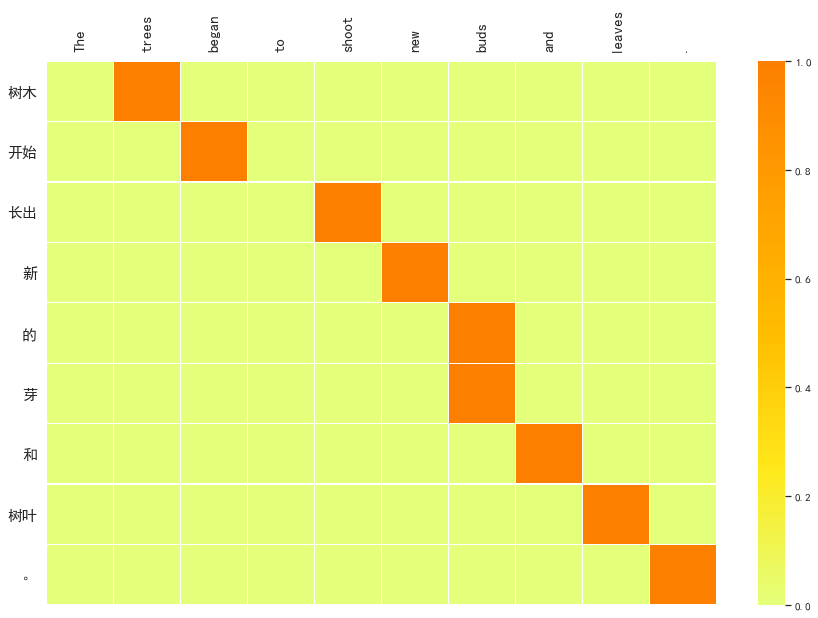

In [141]:
with torch.no_grad():
    index = 54
    print(test_data[index].src)
    print(' '.join(test_data[index].src))
    print(''.join(test_data[index].trg))
    src = ' '.join(test_data[index].src)
    attns, x_labels = beam_search(src, 3)
    print(x_labels)
    
    f, ax = plt.subplots(figsize=(15, 10))
    cmap =sns.diverging_palette(128, 240,as_cmap=True)

    sns.heatmap(attns, cmap='Wistia', linewidths=0.05, ax=ax,  xticklabels=test_data[index].src, yticklabels=x_labels)
    ax.tick_params(axis='y', labelsize=15,labeltop=True)
    ax.tick_params(axis='x', labelsize=15,labeltop=True, labelbottom=False)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
